# Pheme dataset - Fake new detection

In [1]:
# IMPORT

# Base libraries
import pandas as pd
import numpy as np

# NLP preprocessing
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

# Split and feature engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Model training
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

# Plot
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay


# Set random seed
RANDOM_SEED = 1234

## Preprocessing

### Loading the data and descriptive statisitics

In [2]:
# File path
pheme_path = 'Pheme_dataset/dataset.csv'


# Load the dataaset
pheme_df = pd.read_csv(pheme_path)


# Remove unnecessary features from the dataset
pheme = pheme_df.drop(columns=['user.handle', 'topic'])

In [3]:
# Head of the dataset 
pheme.head(10)

,text,is_rumor
0,Charlie Hebdo became well known for publishing...,0.0
1,"Now 10 dead in a shooting there today RT ""@BBC...",0.0
2,@BBCDanielS @BBCWorld I'm guessing this is bei...,0.0
3,@BBCDanielS @BBCWorld why would you mention th...,0.0
4,@BBCDanielS @BBCWorld perps identified?,0.0
5,@BBCDanielS @BBCWorld who is charlie hebdo?,0.0
6,@im_a_5H_Voter A French satirical magazine,0.0
7,@GabTarquini @BBCDanielS @BBCWorld Maybe becau...,0.0
8,@S_Jakobsen @BBCDanielS @BBCWorld what's your ...,0.0
9,@GabTarquini @BBCDanielS @BBCWorld Several men...,0.0


In [4]:
# Shape of data object
pheme.shape

(62445, 2)

In [5]:
# Info about data object
pheme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62445 entries, 0 to 62444
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      62445 non-null  object 
 1   is_rumor  62443 non-null  float64
dtypes: float64(1), object(1)
memory usage: 975.8+ KB


In [6]:
# Column names of dataframe
pheme.columns

Index(['text', 'is_rumor'], dtype='object')

In [7]:
# Drop duplicates
pheme = pheme.drop_duplicates()

### Missing values

In [8]:
# Check how many missing values there are in the dataset
pheme.isnull().sum().sum()

2

In [9]:
# Check in which column(s)
pheme.isnull().any()

text        False
is_rumor     True
dtype: bool

These 2 missing values are both in the label ('is_rumor') column. Thus, there is nothing else to do than remove these.

In [10]:
# Check unique values of the label ('is_rumor') cloumn
print(pheme['is_rumor'].unique())

[ 0.  1. nan]


In [11]:
# Delete the null-valued rows from the dataset
pheme = pheme.dropna()

In [12]:
# Changing the data type of the "is_rumor" column from float to int
pheme['is_rumor'] = pheme['is_rumor'].astype(int)

In [13]:
# Number of instances with label ('is_rumor') 0 and 1
pheme["is_rumor"].value_counts()

0    47875
1    13529
Name: is_rumor, dtype: int64

### Preparing data for analysis

In [14]:
# Flipping the label encoding (1 --> 0, 0 --> 1) and chaning the column name
pheme['is_rumor'] = pheme.loc[:, 'is_rumor'].replace({1: 0, 0: 1})
pheme.rename(columns={'is_rumor': 'is_real'}, inplace=True)

#### Tokenization

In [15]:
# Create new column with tokens
pheme['tokens'] = pheme.apply(lambda row: word_tokenize(row['text']), axis=1)

#### Lemmatization

In [16]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()


# Create new column with lemmas
pheme['lemma'] = pheme.apply(lambda row: [lemmatizer.lemmatize(token.lower()) for token in row["tokens"]], axis=1)

#### Stopword removal

In [17]:
# Load the english stopwords
english_stop_words = stopwords.words('english')


# Create new column without stopwords
pheme['stopword'] = pheme.apply(lambda row: [token for token in row["lemma"] if token not in english_stop_words], axis=1)

#### Final string creation

In [18]:
# Create new column with joined tokens (as TD-IDF takes a string as input)
pheme['final'] = pheme.apply(lambda row: " ".join(row['stopword']), axis=1)

In [19]:
# Head of the created dataaset
pheme.head()

,text,is_real,tokens,lemma,stopword,final
0,Charlie Hebdo became well known for publishing...,1,"[Charlie, Hebdo, became, well, known, for, pub...","[charlie, hebdo, became, well, known, for, pub...","[charlie, hebdo, became, well, known, publishi...",charlie hebdo became well known publishing muh...
1,"Now 10 dead in a shooting there today RT ""@BBC...",1,"[Now, 10, dead, in, a, shooting, there, today,...","[now, 10, dead, in, a, shooting, there, today,...","[10, dead, shooting, today, rt, ``, @, bbcdani...",10 dead shooting today rt `` @ bbcdaniels : ch...
2,@BBCDanielS @BBCWorld I'm guessing this is bei...,1,"[@, BBCDanielS, @, BBCWorld, I, 'm, guessing, ...","[@, bbcdaniels, @, bbcworld, i, 'm, guessing, ...","[@, bbcdaniels, @, bbcworld, 'm, guessing, con...",@ bbcdaniels @ bbcworld 'm guessing considered...
3,@BBCDanielS @BBCWorld why would you mention th...,1,"[@, BBCDanielS, @, BBCWorld, why, would, you, ...","[@, bbcdaniels, @, bbcworld, why, would, you, ...","[@, bbcdaniels, @, bbcworld, would, mention, k...",@ bbcdaniels @ bbcworld would mention knowing ...
4,@BBCDanielS @BBCWorld perps identified?,1,"[@, BBCDanielS, @, BBCWorld, perps, identified...","[@, bbcdaniels, @, bbcworld, perps, identified...","[@, bbcdaniels, @, bbcworld, perps, identified...",@ bbcdaniels @ bbcworld perps identified ?


#### Splitting data and feature engineering

##### Splitting

In [20]:
# Split the data into train set and test set (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(pheme['final'], pheme['is_real'], test_size=0.3, random_state=RANDOM_SEED, stratify=pheme['is_real'])

##### TF-IDF

In [21]:
# Initialize vectorizer with token pattern to remove numbers, single characters and 
# non-latin alphabet characters
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[A-Za-z]{3,}\b')


# Fit-transform to taining data
X_train_tfidf = vectorizer.fit_transform(X_train)


# Transform test data
X_test_tfidf = vectorizer.transform(X_test)

In [22]:
# # Matrix to see the result
# df_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=range(1, len(X_train)+1))


# # Display the TF-IDF matrix
# print("TF-IDF Matrix:")
# print(df_train_tfidf.head())

In [23]:
# # Matrix to see the result
# df_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=range(1, len(X_test)+1))


# # Display the TF-IDF matrix
# print("TF-IDF Matrix:")
# print(df_test_tfidf.head())

## Model training

### Support Vector Machine/Classifier

In [24]:
# Instantiate SVM
svc = SVC(random_state=RANDOM_SEED)


# Parameter grid dictionary
param_grid_svc = [
    {'C':[1.0, 10.0, 100.0], 
     'kernel':['linear', 'poly', 'rbf']}
]


# Instantiate GridSearchCV and fit it to the training data
search_svc = GridSearchCV(svc, param_grid_svc, cv=5, n_jobs=-1)
search_svc.fit(X_train_tfidf, y_train)


# Print the best estimator
print(search_svc.best_estimator_)


# Save the best parameters in a variable 
best_params_svc = search_svc.best_params_

SVC(C=10.0, random_state=1234)


#### Final model

In [25]:
# Instantiate SVM
svc = SVC(**best_params_svc, random_state=RANDOM_SEED)


# Fit the model to training data
svc.fit(X_train_tfidf, y_train)

SVC(C=10.0, random_state=1234)

In [26]:
# Predict the labels of the test set
svc_pred_labels = svc.predict(X_test_tfidf)

### Random Forest

#### Grid search

In [27]:
# Instantiate Random Forest
rf = RandomForestClassifier(random_state=RANDOM_SEED)


# Parameter grid dictionary
grid_dict_rf = [
    {'max_depth': [None, 10, 20], 
     'min_samples_split': [2, 5, 10],
     'n_estimators':[50, 100, 200]}
]


# Instantiate GridSearchCV and fit it to the training data
search_rf = GridSearchCV(rf, grid_dict_rf, cv=5, n_jobs=-1) 
search_rf.fit(X_train_tfidf, y_train)


# Print the best estimator
print(search_rf.best_estimator_)


# Save the best parameters in a variable 
best_params_rf = search_rf.best_params_

RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=1234)


#### Final model

In [28]:
# Instantiate Random Forest
rf = RandomForestClassifier(**best_params_rf, random_state=RANDOM_SEED)


# Fit the model to training data
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=1234)

In [29]:
# Predict the labels of the test set
rf_pred_labels = rf.predict(X_test_tfidf)

### Multinomial Naive Bayes

#### Grid search

In [30]:
# Instantiate Multinomial Naive Bayes
mnb = MultinomialNB()


# Parameter grid dictionary
grid_dict_mnb = [
    {'alpha': [0.01, 0.1, 1]}
]


# Instantiate GridSearchCV and fit it to the training data
search_mnb = GridSearchCV(mnb, grid_dict_mnb, cv=5, n_jobs=-1) 
search_mnb.fit(X_train_tfidf, y_train)


# Print the best estimator
print(search_mnb.best_estimator_)


# Save the best parameters in a variable 
best_params_mnb = search_mnb.best_params_

MultinomialNB(alpha=0.01)


#### Final model

In [31]:
# Instantiate 
mnb = MultinomialNB(**best_params_mnb)


# Fit the model to training data
mnb.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.01)

In [32]:
# Predict the labels of the test set
mnb_pred_labels = mnb.predict(X_test_tfidf)

## Model evaluation

### Support Vector Machine/Classifier

In [46]:
# Calculate different performance measures
accuracy_score_svc = accuracy_score(y_test , svc_pred_labels)
precision_score_svc = precision_score(y_test , svc_pred_labels, average='weighted')
recall_score_svc = recall_score(y_test, svc_pred_labels, average='weighted')
f1_score_svc = f1_score(y_test, svc_pred_labels, average='weighted')


# Print the different performance measures
print("SVC Results:",
      "\nDataset:\t Pheme",
      "\nModel parameters:", search_svc.best_params_,
      "\nAccuracy:\t", accuracy_score_svc,
      "\nPrecision:\t", precision_score_svc, 
      "\nRecall:\t\t",  recall_score_svc, 
      "\nF1-score:\t", f1_score_svc)


# Classification report for SVC
print('\n\n\nClassification report SVC (Pheme):\n')
print(classification_report(y_test, svc_pred_labels, digits=4))

SVC Results: 
Dataset:	 Pheme 
Model parameters: {'C': 10.0, 'kernel': 'rbf'} 
Accuracy:	 0.8978395396808164 
Precision:	 0.8956928792644658 
Recall:		 0.8978395396808164 
F1-score:	 0.8917306368799299



Classification report SVC (Pheme):

              precision    recall  f1-score   support

           0     0.8676    0.6329    0.7319      4059
           1     0.9036    0.9727    0.9369     14363

    accuracy                         0.8978     18422
   macro avg     0.8856    0.8028    0.8344     18422
weighted avg     0.8957    0.8978    0.8917     18422



### Random Forest

In [44]:
# Calculate different performance measures
accuracy_score_rf = accuracy_score(y_test , rf_pred_labels)
precision_score_rf = precision_score(y_test , rf_pred_labels, average='weighted')
recall_score_rf = recall_score(y_test, rf_pred_labels, average='weighted')
f1_score_rf = f1_score(y_test, rf_pred_labels, average='weighted')


# Print the different performance measures
print("Random Forest Results:",
      "\nDataset:\t Pheme",
      "\nModel parameters:", search_rf.best_params_,
      "\nAccuracy:\t", accuracy_score_rf,
      "\nPrecision:\t", precision_score_rf, 
      "\nRecall:\t\t",  recall_score_rf, 
      "\nF1-score:\t", f1_score_rf)


# Classification report for Random Forest
print('\n\n\nClassification report Random Forest (Pheme):\n')
print(classification_report(y_test, rf_pred_labels, digits=4))

Random Forest Results: 
Dataset:	 Pheme 
Model parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200} 
Accuracy:	 0.8918141352730431 
Precision:	 0.8890319513365355 
Recall:		 0.8918141352730431 
F1-score:	 0.8850344171588562



Classification report Random Forest (Pheme):

              precision    recall  f1-score   support

           0     0.8540    0.6139    0.7143      4059
           1     0.8989    0.9703    0.9333     14363

    accuracy                         0.8918     18422
   macro avg     0.8765    0.7921    0.8238     18422
weighted avg     0.8890    0.8918    0.8850     18422



### Multinomial Naive Bayes

In [45]:
# Calculate different performance measures
accuracy_score_mnb = accuracy_score(y_test , mnb_pred_labels)
precision_score_mnb = precision_score(y_test , mnb_pred_labels, average='weighted')
recall_score_mnb = recall_score(y_test, mnb_pred_labels, average='weighted')
f1_score_mnb = f1_score(y_test, mnb_pred_labels, average='weighted')


# Print the different performance measures
print("Multinomial Naive Bayes:",
      "\nDataset:\t Pheme",
      "\nModel parameters:", search_mnb.best_params_,
      "\nAccuracy:\t", accuracy_score_mnb,
      "\nPrecision:\t", precision_score_mnb, 
      "\nRecall:\t\t",  recall_score_mnb, 
      "\nF1-score:\t", f1_score_mnb)


# Classification report for Multinomial Naive Bayes
print('\n\n\nClassification report Multinomial Naive Bayes (Pheme):\n')
print(classification_report(y_test, mnb_pred_labels, digits=4))

Multinomial Naive Bayes: 
Dataset:	 Pheme 
Model parameters: {'alpha': 0.01} 
Accuracy:	 0.881880360438606 
Precision:	 0.8781545167514865 
Recall:		 0.881880360438606 
F1-score:	 0.8735775041534256



Classification report Multinomial Naive Bayes (Pheme):

              precision    recall  f1-score   support

           0     0.8354    0.5777    0.6831      4059
           1     0.8902    0.9678    0.9274     14363

    accuracy                         0.8819     18422
   macro avg     0.8628    0.7728    0.8052     18422
weighted avg     0.8782    0.8819    0.8736     18422



### AUC and AUPRC

Average Precision SVC (fake news): 0.8265274970671852
Average Precision RF (fake news): 0.8259790042066092
Average Precision MNB (fake news): 0.810561185687016
Average Precision SVC (real news): 0.9724396356341547
Average Precision RF (real news): 0.9678219875958213
Average Precision MNB (real news): 0.9746989978594113


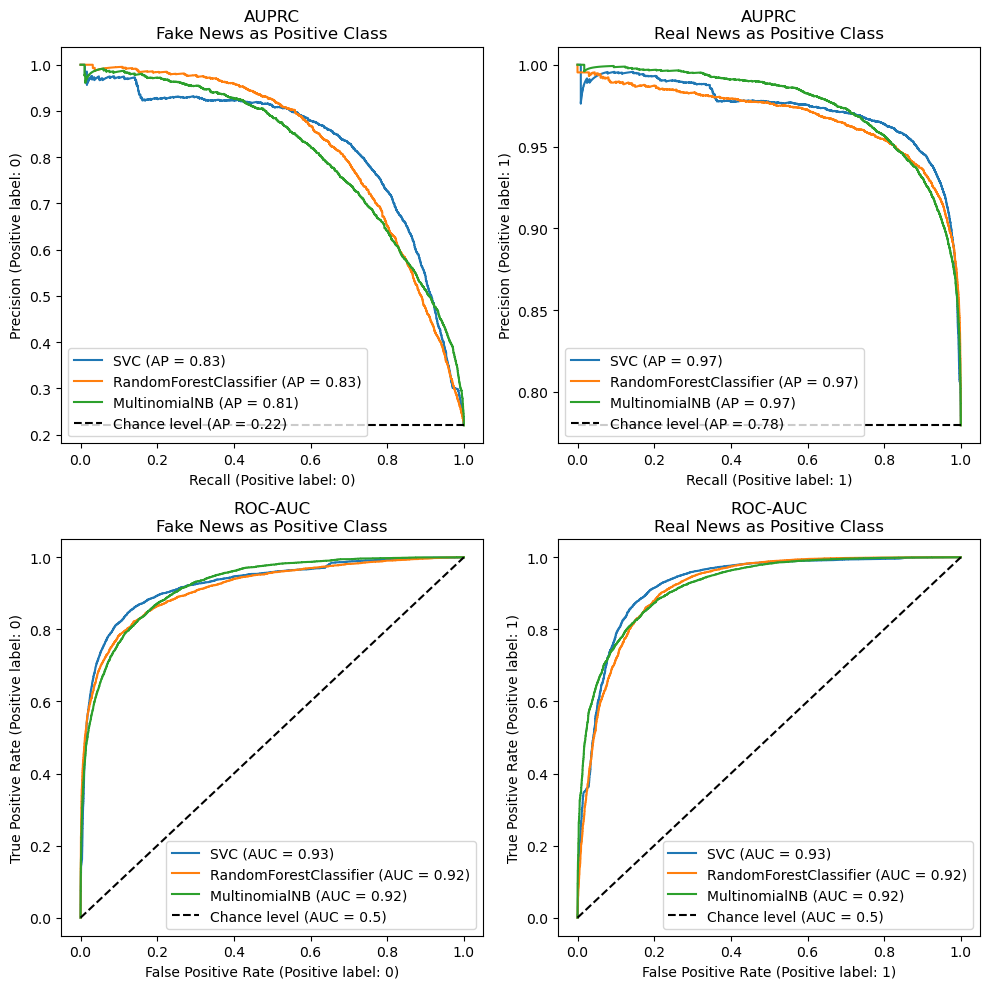

In [42]:
# Create plot canvas with subplot spaces
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# AUPRC
print('Average Precision SVC (fake news):',
    PrecisionRecallDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[0, 0]).average_precision)

print('Average Precision RF (fake news):',
    PrecisionRecallDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[0, 0]).average_precision)

print('Average Precision MNB (fake news):',
    PrecisionRecallDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[0, 0],
    plot_chance_level=True).average_precision)

print('Average Precision SVC (real news):',
    PrecisionRecallDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[0, 1]).average_precision)

print('Average Precision RF (real news):',
    PrecisionRecallDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[0, 1]).average_precision)

print('Average Precision MNB (real news):',
    PrecisionRecallDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[0, 1],
    plot_chance_level=True).average_precision)

axs[0, 0].set_title('AUPRC\nFake News as Positive Class')
axs[0, 1].set_title('AUPRC\nReal News as Positive Class')


# AUC
RocCurveDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[1, 0])

RocCurveDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[1, 0])

RocCurveDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[1, 0],
    plot_chance_level=True)

RocCurveDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[1, 1])

RocCurveDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[1, 1])

RocCurveDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[1, 1],
    plot_chance_level=True)

axs[1, 0].set_title('ROC-AUC\nFake News as Positive Class')
axs[1, 1].set_title('ROC-AUC\nReal News as Positive Class')

plt.tight_layout()